# Black Lives Matter: Topic Modeling

### This pipeline is intended to retrieve and model topics for Tweets containing terms not related to Michael Brown or Ferguson

This analysis was inspired by the [_Topic Modeling with Gensim (Python)_ post](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/), which can be found on the Machine Learning Plus blog.

This version of the pipeline skips some descriptive steps that can be found on the ferguson_mikebrown.ipynb file.

## Import libraries

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rosarodriguez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from collections import Counter
import random

In [3]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas_gbq

In [4]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, ldamodel
from gensim.test.utils import datapath

In [5]:
# spacy for lemmatization
import spacy

In [6]:
# Plotting tools
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

In [7]:
# Parallelize prediction
import multiprocessing

In [8]:
import pyLDAvis
import pyLDAvis.gensim

In [9]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [10]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [11]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['url','ferguson', 'michael', 'mike', 'brown', 'michaelbrown', 'mikebrown'])

## Import data

In [12]:
%env GOOGLE_APPLICATION_CREDENTIALS = ../dsi-capstone-f19-group-1-198add732865.json

env: GOOGLE_APPLICATION_CREDENTIALS=../dsi-capstone-f19-group-1-198add732865.json


In [13]:
%load_ext google.cloud.bigquery

In [14]:
%%bigquery df
SELECT DISTINCT full_text_cleaned AS full_text
FROM tweets.all_valid_tweets
WHERE michael_brown = 0 AND ferguson_ht = 0 AND is_retweet = FALSE

In [15]:
data = list(df['full_text'])

## Pre-processing tweets

### Decompose into bag of words

Let's take a tweet in our data:

In [16]:
tweet = 'News: Ma who shot video of Eric Garner in apparent choke hold arrested on firearms charges.'
print(tweet)

News: Ma who shot video of Eric Garner in apparent choke hold arrested on firearms charges.


Now we will decompose this tweet into an array of words, where the order doesn't matter.

In [17]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
    
data_words = list(sent_to_words(data))

#Example
tweet_words = list(sent_to_words([tweet]))
print(tweet_words[0])

['news', 'ma', 'who', 'shot', 'video', 'of', 'eric', 'garner', 'in', 'apparent', 'choke', 'hold', 'arrested', 'on', 'firearms', 'charges']


### Stop words

There are commonly used words (such as “the”, “a”, “an”, “in”) which appear that often, that are useless to understand the context we are analyzing. Moreover, since they are common, they make the NLP techniques to spend more time processing, without adding any value. Therefore, we will remove them from every tweet.

In [18]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def unique_list_of_lists(lol):
    unique_lol = set(map(tuple, lol))
    unique_lol = list(map(list, unique_lol))
    return(unique_lol)

# Remove Stop Words
data_words_nostops = unique_list_of_lists(remove_stopwords(data_words))

#Example
tweet_words_nostops = remove_stopwords(tweet_words)
print(tweet_words_nostops[0])

['news', 'shot', 'video', 'eric', 'garner', 'apparent', 'choke', 'hold', 'arrested', 'firearms', 'charges']


### Bigrams and Trigrams

There are concepts like _Eric Garner_ or _New York_ which make more sense to be analyzed as a single word, than being split into two. To achieve that we will use the concept of bigrams and trigrams.

In [19]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words_nostops, min_count=5, threshold=20) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words_nostops], threshold=20)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [20]:
def make_bigrams(texts):
    return [remove_underscore(bigram_mod[doc]) for doc in texts]

def make_trigrams(texts):
    return [remove_underscore(trigram_mod[bigram_mod[doc]]) for doc in texts]

def remove_underscore(doc):
    return([re.sub("_", "", word) for word in doc])

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [21]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Example
tweet_words_bigrams = make_bigrams(tweet_words_nostops)
print(tweet_words_bigrams[0])

['news', 'shot', 'video', 'eric', 'garner', 'apparentchoke', 'hold', 'arrested', 'firearms', 'charges']


### Lemmatization

Finally, we would like to tackle one last challenge: The fact that a word used as a singular or plural should be considered the same. Similar case when you conjugate a verb or you use verbs and adjectives with the same origin. 

These kinds of problems are solved by _Lemmatization_ , a technique that transforms any single word to its root.

In [22]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized =  unique_list_of_lists(remove_stopwords(
    lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
))

# Example
tweet_lemmatized = lemmatization(tweet_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(tweet_lemmatized[0])

['news', 'shoot', 'video', 'hold', 'arrest', 'firearm', 'charge']


## Modeling topics

### Build corpora

Once we have the pre-processed tweets we want to model, we need to make them comparable on a mathematical way. To achieve that, we will create as many dimensions as we have unique words in the set of tweets. Then, we will assign to each word the number of times it was mentioned in the tweet (and zero if it didn't appear).

In [23]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Example
print(id2word.doc2bow(tweet_lemmatized[0]))

[(13, 1), (79, 1), (137, 1), (195, 1), (232, 1), (350, 1), (2398, 1)]


In [24]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in [id2word.doc2bow(tweet) for tweet in tweet_lemmatized]]

[[('video', 1),
  ('shoot', 1),
  ('arrest', 1),
  ('charge', 1),
  ('hold', 1),
  ('news', 1),
  ('firearm', 1)]]

### LDA Model

To model the different topics, we are going to use the Latent Dirichlet Allocation (LDA) technique. Specifically, we are going to use the Mallet implementation, which is a Java-based package for statistical NLP.

### Choosing the right number of topics

As on the original pipeline file, we would like to optimize the hyper-parameter for number of topics, as well to improve the model performance. To achieve that we will use the Coherence Score, trying different values, and analyzing which is the one with the best performance.

In [25]:
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path

In [26]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        mallet_model = gensim.models.wrappers.LdaMallet(mallet_path,
                                            corpus=corpus,
                                            num_topics=num_topics,
                                            id2word=id2word,
                                            alpha=1,
                                            optimize_interval=50,
                                            workers=7,
                                            random_seed=2019)
        
        model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mallet_model)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [27]:
# Can take a long time to run.
limit = 18
start = 6
step = 2
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=texts, 
                                                        start=start, 
                                                        limit=limit,
                                                        step=step)

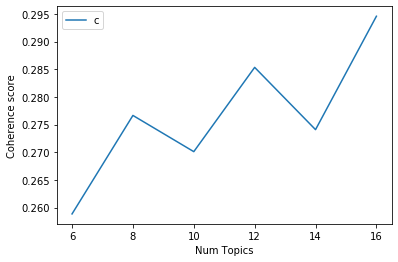

In [28]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [29]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 6  has Coherence Value of 0.2589
Num Topics = 8  has Coherence Value of 0.2766
Num Topics = 10  has Coherence Value of 0.2701
Num Topics = 12  has Coherence Value of 0.2853
Num Topics = 14  has Coherence Value of 0.2741
Num Topics = 16  has Coherence Value of 0.2946


### Working with the optimal model -> Pause here

The model that maximized coherence was the one with 16 topics. We will work with that parameter.

In [32]:
file_name = 'optimal_model_neither'

In [33]:
# optimal_model = model_list[5]
# optimal_model.save(file_name)

In [34]:
optimal_model = ldamodel.LdaModel.load(file_name, mmap='r')
id2word = corpora.Dictionary.load('optimal_model_neither.id2word', mmap='r')

In [35]:
# Print the topics
pprint(optimal_model.show_topics(formatted=False, num_topics=20))

[(0,
  [('death', 0.18166455428812844),
   ('garner', 0.09125475285171103),
   ('ruledhomicide', 0.05348542458808619),
   ('chokehold', 0.042416561047739755),
   ('police', 0.039966201943388256),
   ('rule', 0.03802281368821293),
   ('homicide', 0.028897338403041824),
   ('officer', 0.020194338825517532),
   ('ericgarner', 0.017405999155048583),
   ('case', 0.016476552598225603)]),
 (1,
  [('ezellford', 0.08791801510248112),
   ('kill', 0.0850413520316433),
   ('police', 0.06373606616325063),
   ('man', 0.06328658755843222),
   ('shoot', 0.05519597267170083),
   ('black', 0.03407047824523553),
   ('lapd', 0.0321826681049982),
   ('unarmed', 0.022563825961884214),
   ('murder', 0.019147788565264293),
   ('officer', 0.018518518518518517)]),
 (2,
  [('police', 0.053691275167785234),
   ('ericgarner', 0.025668197338985045),
   ('black', 0.02425526904509596),
   ('brutality', 0.02319557282467915),
   ('victim', 0.013658306840927822),
   ('violence', 0.012716354645001766),
   ('end', 0.01224

## Exploring the results

### Dominant topic in each sentence

In [36]:
def create_corpus(data):
    data_words = list(sent_to_words(data))
    data_words_nostops = remove_stopwords(data_words)
    data_words_bigrams = make_bigrams(data_words_nostops)
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    corpus = [id2word.doc2bow(text) for text in data_lemmatized]
    return(corpus)


def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()
    words = list(sent_to_words(texts))
    
    try:
        cpus = multiprocessing.cpu_count()
    except NotImplementedError:
        cpus = 7   # arbitrary default
    
    pool = multiprocessing.Pool(processes=cpus)
    dom_topics_list = pool.map(get_dominant_topic, list(ldamodel[corpus]))
    pool.close()
    
    df_dominant_topic = pd.DataFrame(dom_topics_list)

    # Add original text to the end of the output
    contents = pd.Series(texts)
    bow = pd.Series(words)
    df_dominant_topic = pd.concat([df_dominant_topic, contents, bow], axis=1).reset_index()
    df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Text', 'Words']
    
    topic_keywords_dict = get_topic_keywords_dict(ldamodel)
    df_dominant_topic['Topic_Keywords'] = list(map(
        lambda x:topic_keywords_dict[x],
        df_dominant_topic['Dominant_Topic']
    ))
    df_dominant_topic = df_dominant_topic[['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Topic_Keywords', 'Text', 'Words']]
    
    return(df_dominant_topic)


def get_dominant_topic(topics):
    topic_num, prop_topic = sorted(topics, key=lambda x: (x[1]), reverse=True)[0]
    prop_topic = round(prop_topic,4)
    return(topic_num + 1, prop_topic)


def get_topic_keywords_dict(ldamodel):
    topic_keywords_dict = {}
    for topic in ldamodel.show_topics(formatted=False, num_topics=20):
        topic_num, topic_keywords = topic
        topic_num += 1
        topic_keywords = ", ".join([word for word, prop in topic_keywords])
        topic_keywords_dict[topic_num] = topic_keywords
    return(topic_keywords_dict)

In [37]:
corpus_ = create_corpus(data)
df_dominant_topic = format_topics_sentences(optimal_model, corpus_, data)

In [38]:
# Show
pd.set_option('display.max_colwidth', -1)
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Topic_Keywords,Text,Words
0,0,1,0.5738,"death, garner, ruledhomicide, chokehold, police, rule, homicide, officer, ericgarner, case",eric garners death ruled homicide by medical examiner hoping to see some justice this time,"[eric, garners, death, ruled, homicide, by, medical, examiner, hoping, to, see, some, justice, this, time]"
1,1,1,0.8905,"death, garner, ruledhomicide, chokehold, police, rule, homicide, officer, ericgarner, case",worldstarhiphop medical examiner says police chokehold killed eric garner death ruled a homicide! $URL$ wshh,"[worldstarhiphop, medical, examiner, says, police, chokehold, killed, eric, garner, death, ruled, homicide, url, wshh]"
2,2,10,0.7593,"story, case, ezellford, happen, medium, make, ericgarner, read, news, talk",the unfortunate case of eric garner $URL$,"[the, unfortunate, case, of, eric, garner, url]"
3,3,5,0.4697,"kill, cop, police, officer, murder, people, shoot, train, situation, life",via on staten island thousands protest police tactics $URL$ blacklivesmatter $URL$,"[via, on, staten, island, thousands, protest, police, tactics, url, url]"
4,4,8,0.8861,"protest, ezellford, today, people, thousand, rally, police, death, street, peaceful",“and i like large parties they’re so intimate at small parties there isn’t any privacy ” jordan baker the great gatsby 🎉,"[and, like, large, parties, they, re, so, intimate, at, small, parties, there, isn, any, privacy, jordan, baker, the, great, gatsby]"
5,5,4,0.6343,"video, police, shoot, kill, stlouis, show, cop, watch, release, releasevideo",st louis police release video of kajieme powell killing that appears at odds with their story $URL$ via,"[st, louis, police, release, video, of, kajieme, powell, killing, that, appears, at, odds, with, their, story, url, via]"
6,6,8,0.8618,"protest, ezellford, today, people, thousand, rally, police, death, street, peaceful",and hoping for peace and justice in my own hood the lapd killed ezell ford blocks away from my house and now people are upset,"[and, hoping, for, peace, and, justice, in, my, own, hood, the, lapd, killed, ezell, ford, blocks, away, from, my, house, and, now, people, are, upset]"
7,7,15,0.4337,"arrest, video, murder, charge, garner, film, death, ericgarner, police, cop",are you kidding me?! “ $URL$ man who shot chokehold video of eric garner arrested on weapons charges,"[are, you, kidding, me, url, man, who, shot, chokehold, video, of, eric, garner, arrested, on, weapons, charges]"
8,8,8,0.3864,"protest, ezellford, today, people, thousand, rally, police, death, street, peaceful",city room live coverage of eric garner rally on staten island protesters are marching against aggressive pol $URL$,"[city, room, live, coverage, of, eric, garner, rally, on, staten, island, protesters, are, marching, against, aggressive, pol, url]"
9,9,4,0.8328,"video, police, shoot, kill, stlouis, show, cop, watch, release, releasevideo",how did victor white iii die? autopsy results contradict cops account $URL$ $URL$,"[how, did, victor, white, iii, die, autopsy, results, contradict, cops, account, url, url]"


### Most representative tweets

In [39]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
# Group top 5 sentences under each topic
df_dominant_topic_sorted = pd.DataFrame()

df_dominant_topic_grpd = df_dominant_topic.groupby('Dominant_Topic')

for i, grp in df_dominant_topic_grpd:
    df_dominant_topic_sorted = pd.concat([df_dominant_topic_sorted, 
                                         grp.sort_values(['Topic_Perc_Contrib'], ascending=[0]).head(10)], 
                                         axis=0)

# Reset Index    
df_dominant_topic_sorted.reset_index(drop=True, inplace=True)

# Format
df_dominant_topic_sorted.columns = ['Document_No','Topic_Num', 'Topic_Perc_Contrib', 'Text', 'Words', 'Topic_Keywords']

# Show
df_dominant_topic_sorted

,Document_No,Topic_Num,Topic_Perc_Contrib,Text,Words,Topic_Keywords
0,17546,1,0.9417,"death, garner, ruledhomicide, chokehold, police, rule, homicide, officer, ericgarner, case",nyc official calls for police body cameras following ericgarner’s death details $URL$ best idea so far!,"[nyc, official, calls, for, police, body, cameras, following, ericgarner, death, details, url, best, idea, so, far]"
1,13943,1,0.9357,"death, garner, ruledhomicide, chokehold, police, rule, homicide, officer, ericgarner, case",homicide declared in case of new york man choked by police new york eric garner 43 a black father of six $URL$,"[homicide, declared, in, case, of, new, york, man, choked, by, police, new, york, eric, garner, black, father, of, six, url]"
2,30670,1,0.9357,"death, garner, ruledhomicide, chokehold, police, rule, homicide, officer, ericgarner, case",eric garners chokehold death leads to push for criminal charges new york ap — new yorkers enraged by a man $URL$,"[eric, garners, chokehold, death, leads, to, push, for, criminal, charges, new, york, ap, new, yorkers, enraged, by, man, url]"
3,1571,1,0.9357,"death, garner, ruledhomicide, chokehold, police, rule, homicide, officer, ericgarner, case",the new york medical examiner called eric garners death a homicide making the nypd liable nypd has no comment dragthem,"[the, new, york, medical, examiner, called, eric, garners, death, homicide, making, the, nypd, liable, nypd, has, no, comment, dragthem]"
4,6526,1,0.9357,"death, garner, ruledhomicide, chokehold, police, rule, homicide, officer, ericgarner, case",nypd union leader said the medical examiners report finding eric garners death a homicide is a political document $URL$,"[nypd, union, leader, said, the, medical, examiners, report, finding, eric, garners, death, homicide, is, political, document, url]"
5,14886,1,0.9357,"death, garner, ruledhomicide, chokehold, police, rule, homicide, officer, ericgarner, case",i am pro union in this case they suck dcmadness202 ny police unions statement on eric garners death disgusting $URL$,"[am, pro, union, in, this, case, they, suck, dcmadness, ny, police, unions, statement, on, eric, garners, death, disgusting, url]"
6,14236,1,0.9357,"death, garner, ruledhomicide, chokehold, police, rule, homicide, officer, ericgarner, case",nyc official calls for police body cameras following ericgarners death details via logg $URL$,"[nyc, official, calls, for, police, body, cameras, following, ericgarners, death, details, via, logg, url]"
7,30324,1,0.9357,"death, garner, ruledhomicide, chokehold, police, rule, homicide, officer, ericgarner, case",breaking grand jury to be impaneled to investigate death of ericgarner who died in police custody me ruled it homicide via,"[breaking, grand, jury, to, be, impaneled, to, investigate, death, of, ericgarner, who, died, in, police, custody, me, ruled, it, homicide, via]"
8,5614,1,0.9357,"death, garner, ruledhomicide, chokehold, police, rule, homicide, officer, ericgarner, case",eric garners death divides new yorkers over police conduct patrick lynch is a passionate union leader for th $URL$,"[eric, garners, death, divides, new, yorkers, over, police, conduct, patrick, lynch, is, passionate, union, leader, for, th, url]"
9,3407,1,0.9357,"death, garner, ruledhomicide, chokehold, police, rule, homicide, officer, ericgarner, case",eric garners chokehold death leads to push for criminal charges new york ap — new yorkers enraged $URL$ spbnews,"[eric, garners, chokehold, death, leads, to, push, for, criminal, charges, new, york, ap, new, yorkers, enraged, url, spbnews]"


### Topic Distribution

In [40]:
# Number of Documents for Each Topic
topic_counts = df_dominant_topic['Dominant_Topic'].value_counts().sort_index()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4).sort_index()

# Topic Number and Keywords
topic_num_keywords = df_dominant_topic[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates()\
    .sort_values('Dominant_Topic').set_index('Dominant_Topic')

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Topic_Keywords,Num_Documents,Perc_Documents
Dominant_Topic,,,
1,"death, garner, ruledhomicide, chokehold, police, rule, homicide, officer, ericgarner, case",3597,0.1008
2,"ezellford, kill, police, man, shoot, black, lapd, unarmed, murder, officer",2752,0.0771
3,"police, ericgarner, black, brutality, victim, violence, end, murder, community, people",1965,0.0550
4,"video, police, shoot, kill, stlouis, show, cop, watch, release, releasevideo",6341,0.1776
5,"kill, cop, police, officer, murder, people, shoot, train, situation, life",1332,0.0373
6,"case, death, ericgarner, cigarette, police, call, investigation, investigate, evidence, order",1208,0.0338
7,"kill, gun, black, police, man, shoot, cop, people, white, toygun",1617,0.0453
8,"protest, ezellford, today, people, thousand, rally, police, death, street, peaceful",1880,0.0527
9,"blacklive, matter, black, people, white, live, woman, love, life, community",1709,0.0479


## Visualization

### Length

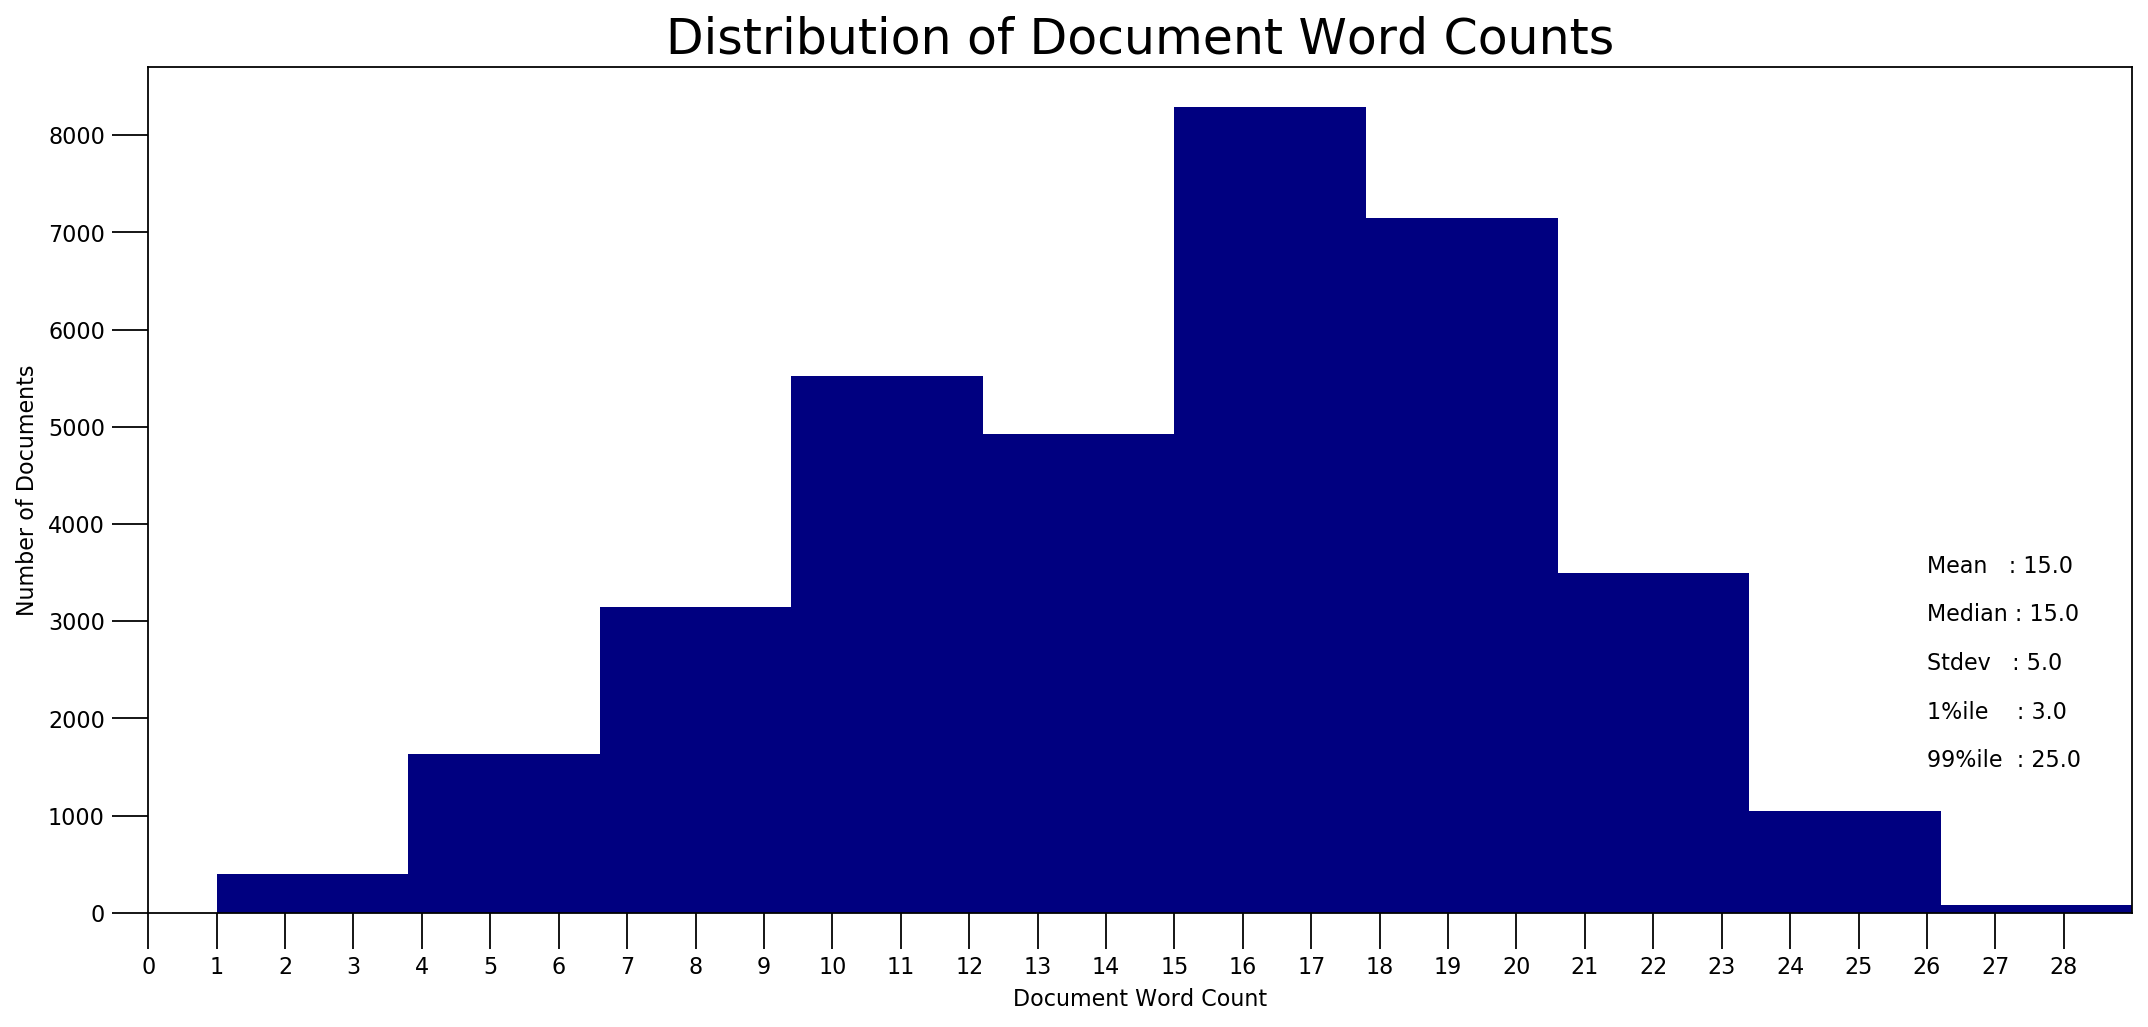

In [49]:
doc_lens = [len(d) for d in data_words]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, color='navy')
plt.text(26, 3500, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(26, 3000, "Median : " + str(round(np.median(doc_lens))))
plt.text(26, 2500, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(26, 2000, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(26, 1500, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, np.max(doc_lens)), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.arange(0,np.max(doc_lens)))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

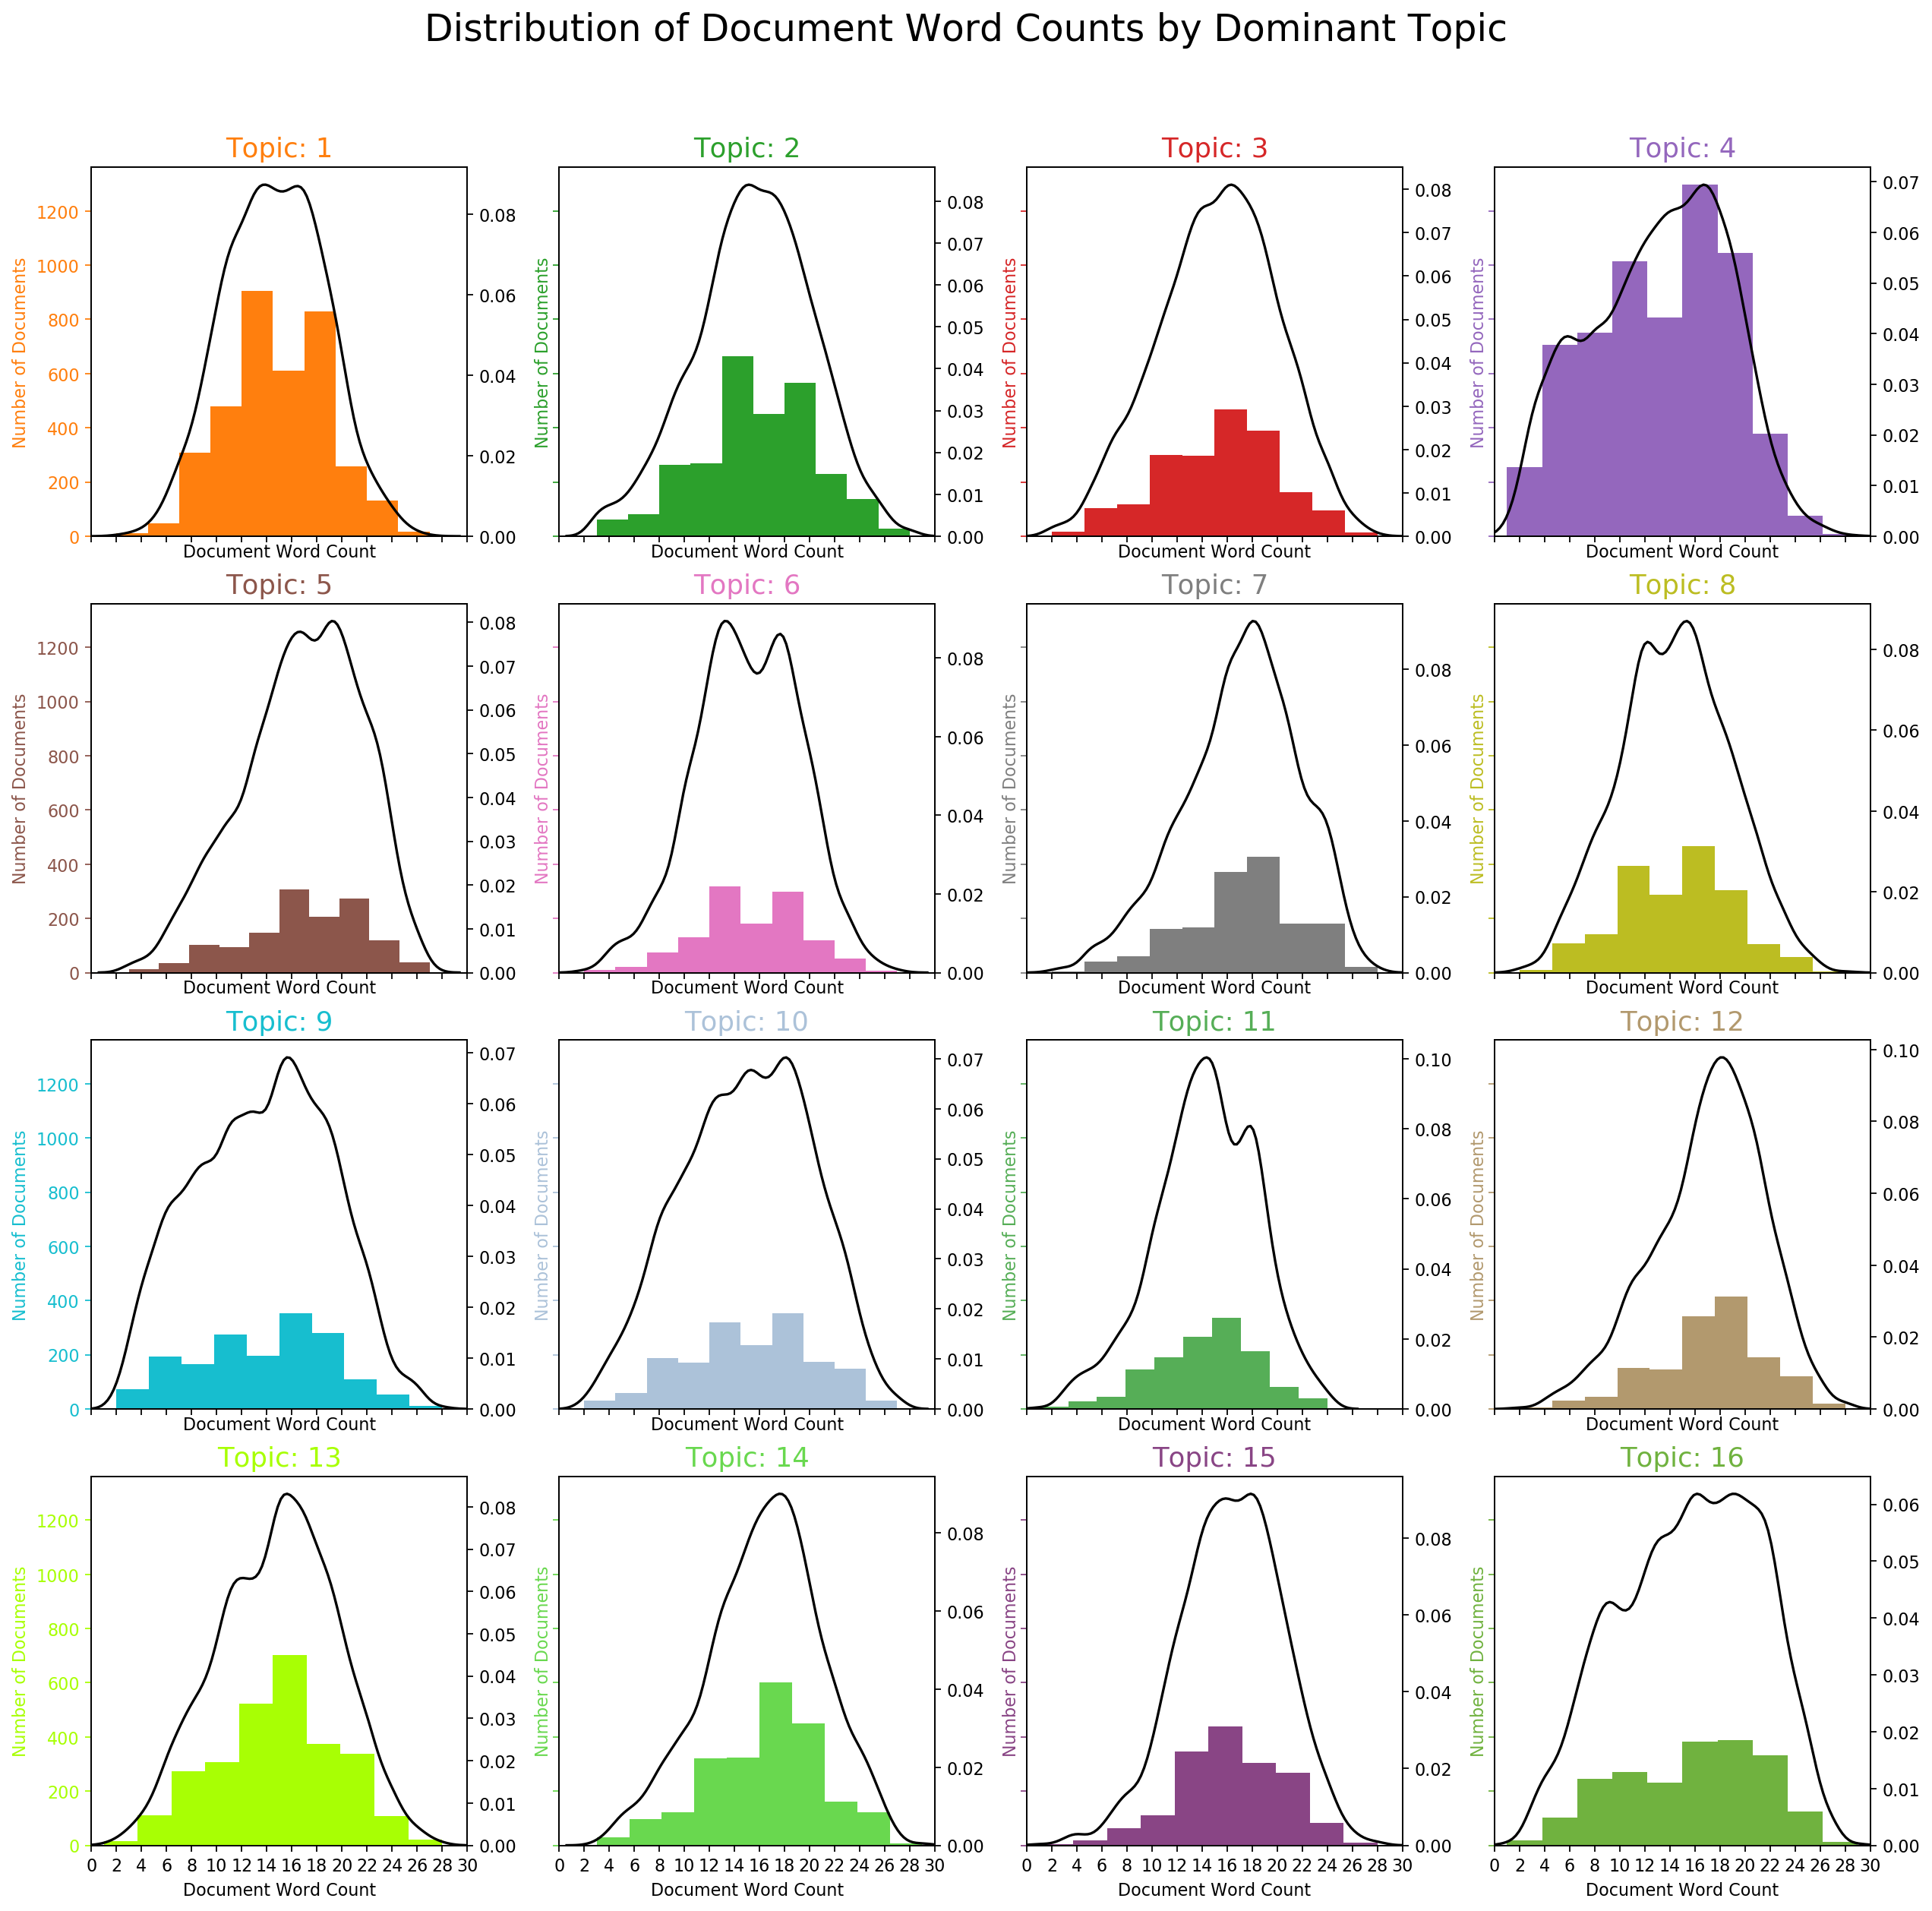

In [43]:
colors = mcolors.TABLEAU_COLORS
colors.update(mcolors.XKCD_COLORS)
cols = [color for name, color in colors.items()]  

fig, axes = plt.subplots(4,4,figsize=(16,16), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    i += 1
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Words]
    ax.hist(doc_lens, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, bw=0.8, ax=ax.twinx())
    ax.set(xlim=(0, 30), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.arange(0, 32, 2))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

### Word Cloud

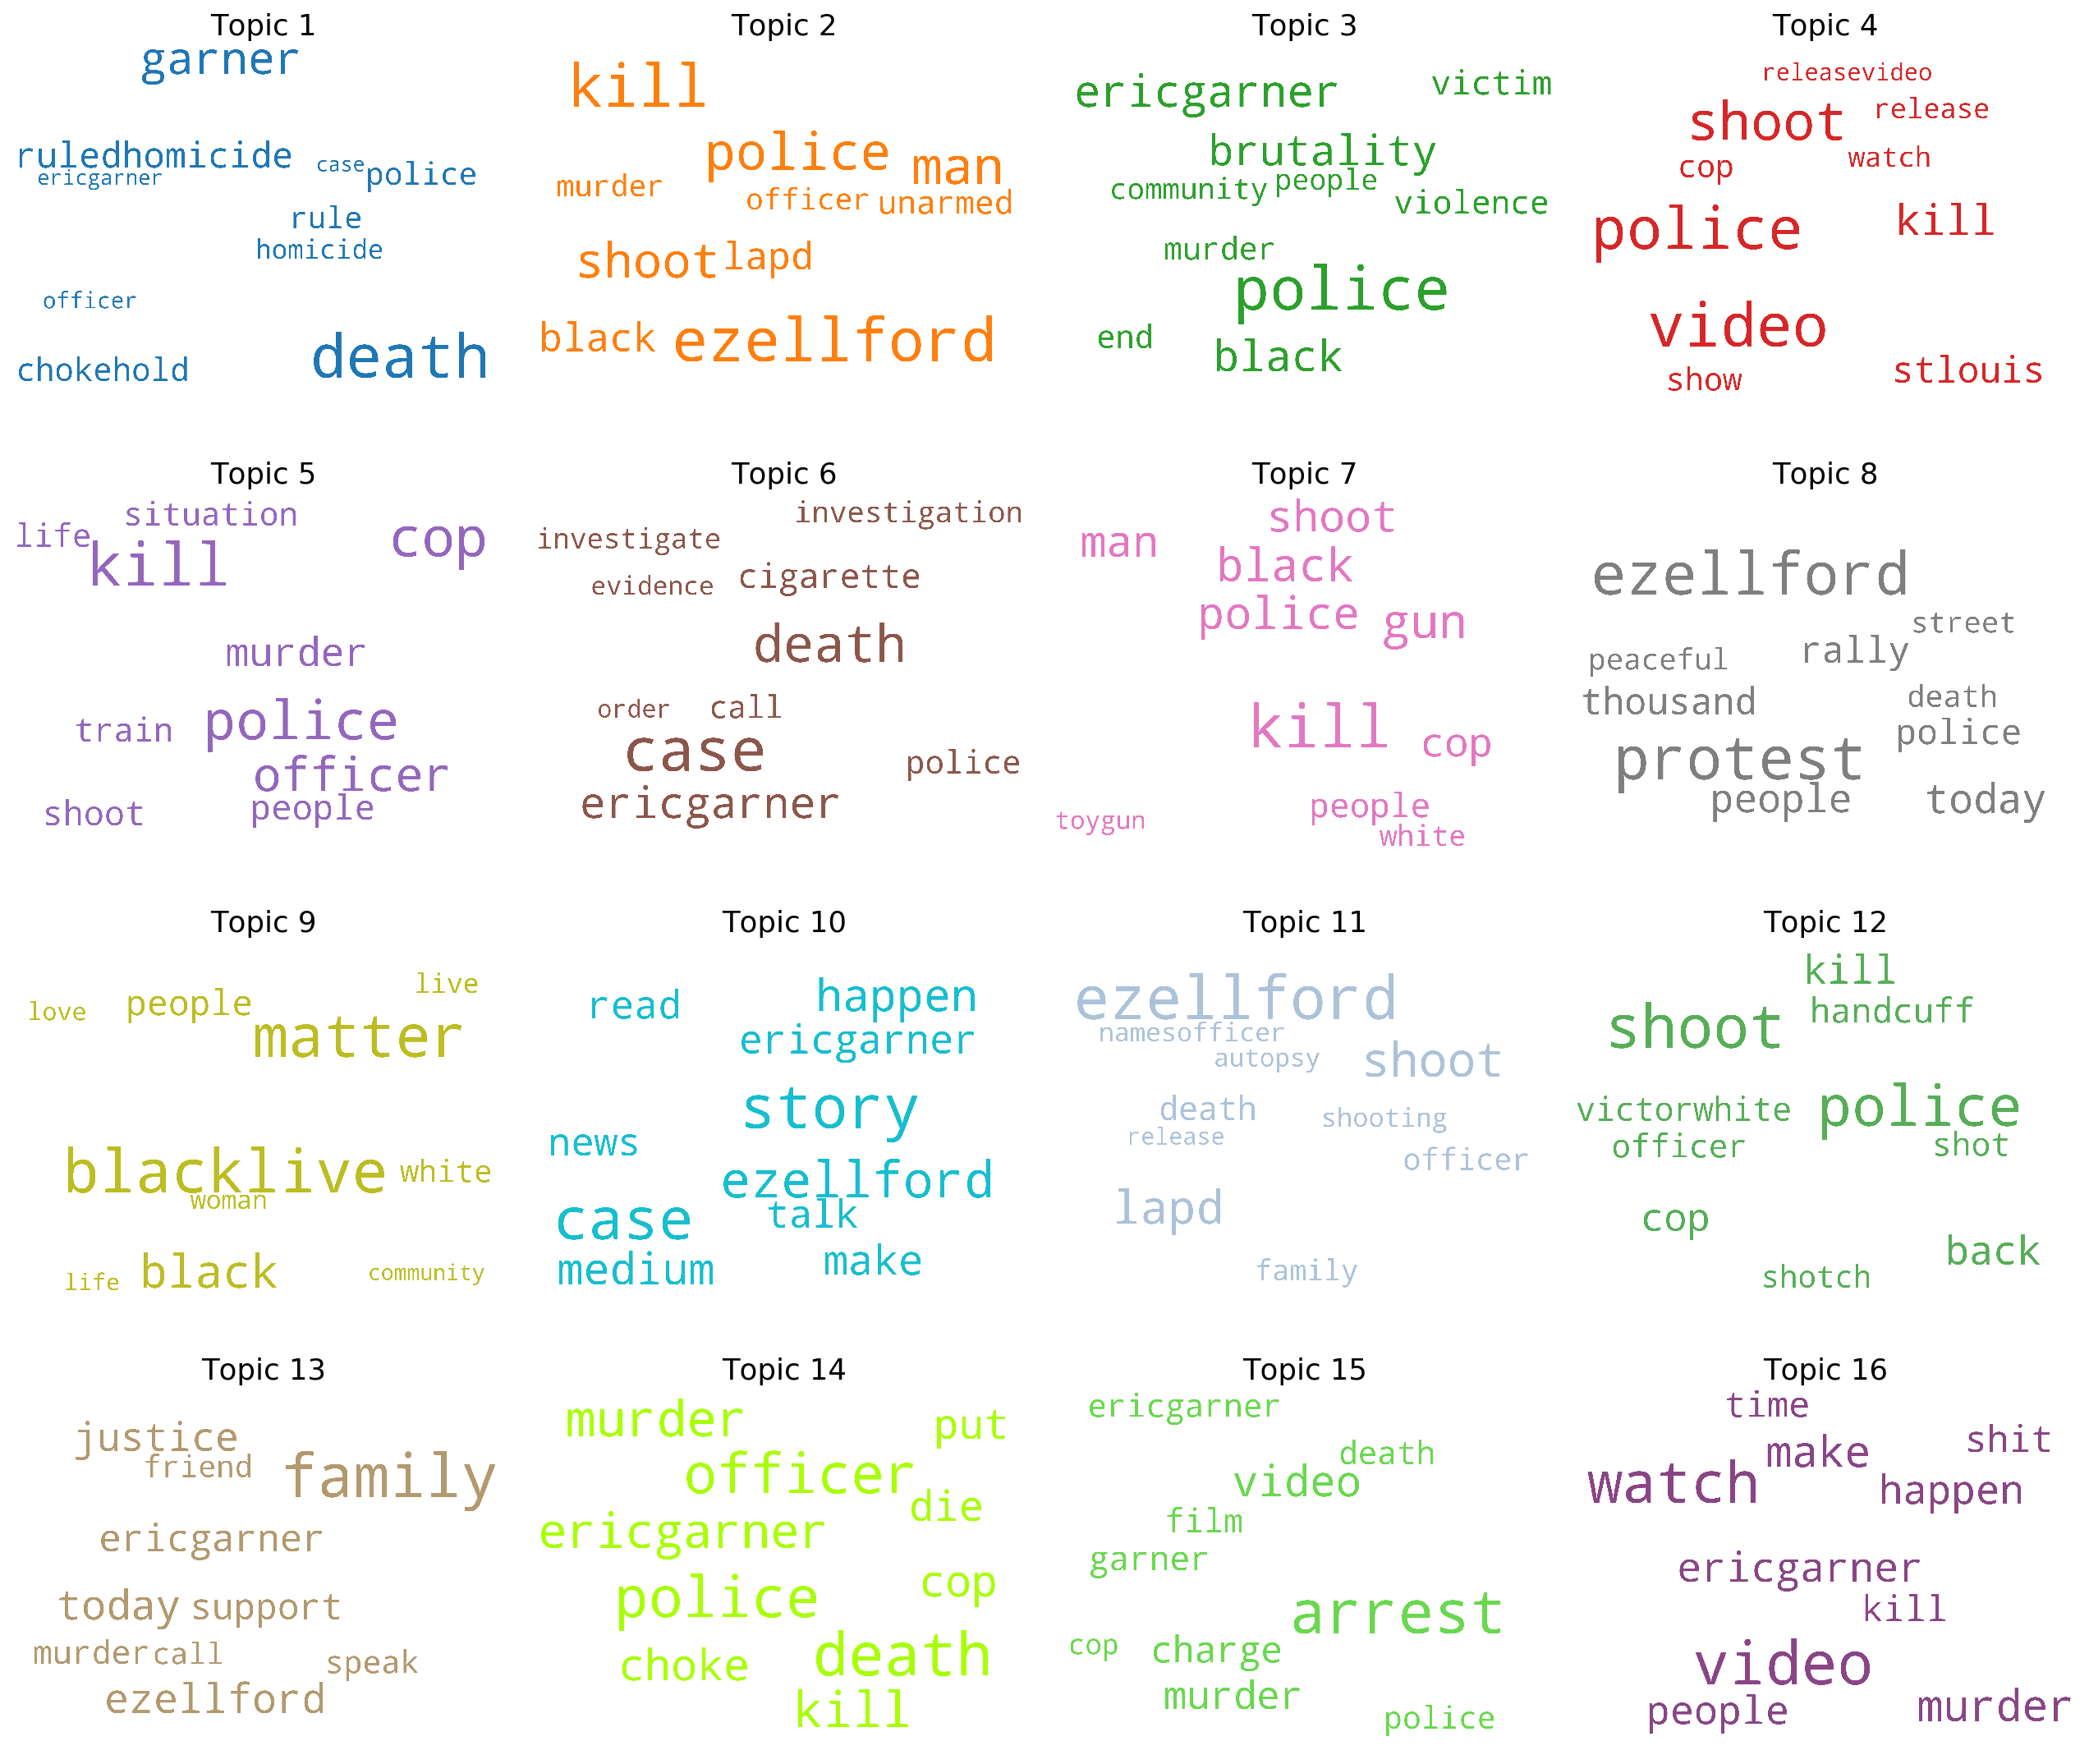

In [44]:
colors = mcolors.TABLEAU_COLORS
colors.update(mcolors.XKCD_COLORS)
cols = [color for name, color in colors.items()]  

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False, num_topics=20)

fig, axes = plt.subplots(4, 4, figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Word count of keywords

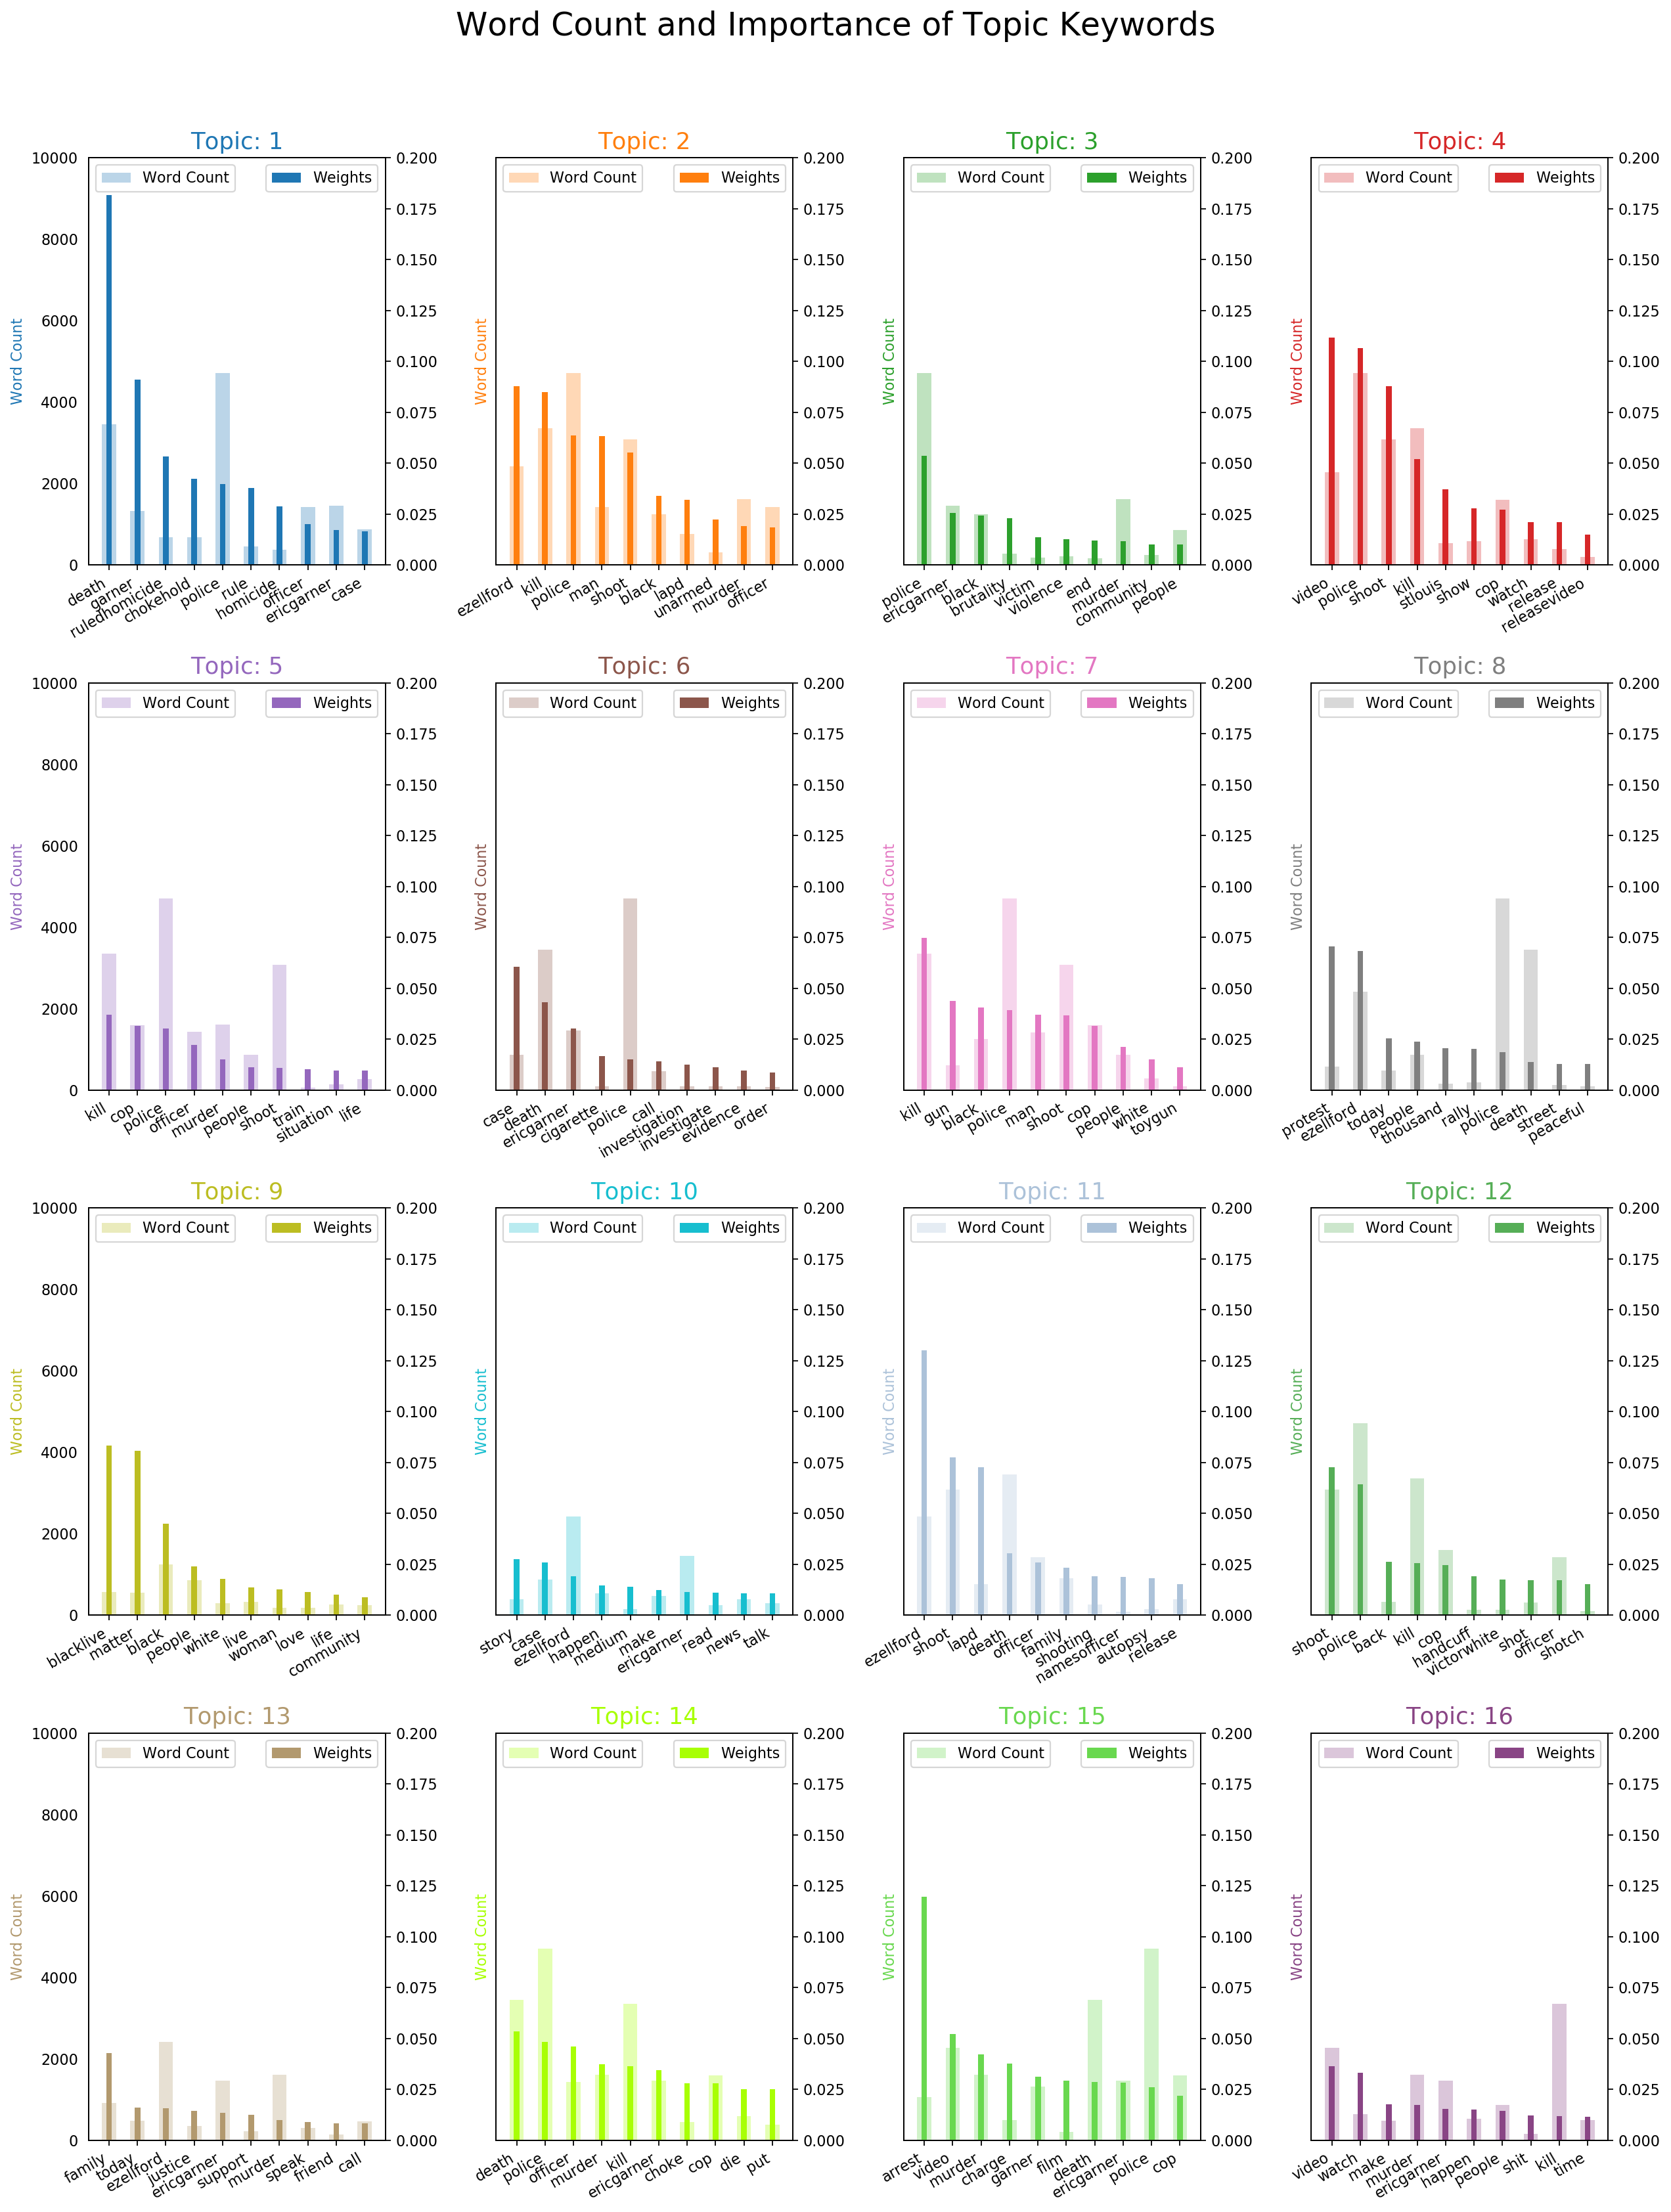

In [47]:
topics = optimal_model.show_topics(formatted=False, num_topics=20)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 4, figsize=(16,20), sharey=True, dpi=160)
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.2); ax.set_ylim(0, 10000)
    ax.set_title('Topic: ' + str(i+1), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout()    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [50]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus_, id2word, sort_topics=False, n_jobs=-1)
vis

/Users/rosarodriguez/anaconda3/envs/coms007/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/rosarodriguez/anaconda3/envs/coms007/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/rosarodriguez/anaconda3/envs/coms007/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/Users/rosarodriguez/anaconda3/envs/coms007/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([def

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.116800  0.293653  1       1        9.642240 
1     -0.118250 -0.178708  2       1        8.349492 
2      0.130402 -0.027453  3       1        6.367706 
3     -0.203455 -0.116251  4       1        10.344918
4     -0.040283 -0.096538  5       1        4.849883 
5      0.073010  0.275699  6       1        3.619115 
6     -0.069995 -0.191112  7       1        5.393809 
7      0.110228 -0.004228  8       1        5.035950 
8      0.292887 -0.109143  9       1        5.239416 
9      0.204783  0.040159  10      1        5.149862 
10    -0.091901 -0.042308  11      1        4.170829 
11    -0.208436 -0.096559  12      1        5.219313 
12     0.254093  0.034974  13      1        7.823634 
13    -0.143111  0.157356  14      1        6.862599 
14    -0.188230  0.123411  15      1        4.900453 
15     0.115057 -0.062954  16      1        7.030781 , topic_info=     Category         Freq             Term        Total  loglift  logprob
term                                                                      
75    Default  4547.000000  death            4547.000000  30.0000  30.0000
76    Default  3138.000000  ezellford        3138.000000  29.0000  29.0000
79    Default  3970.000000  shoot            3970.000000  28.0000  28.0000
13    Default  2896.000000  video            2896.000000  27.0000  27.0000
137   Default  1396.000000  arrest           1396.000000  26.0000  26.0000
114   Default  1753.000000  garner           1753.000000  25.0000  25.0000
78    Default  5956.000000  police           5956.000000  24.0000  24.0000
77    Default  4235.000000  kill             4235.000000  23.0000  23.0000
82    Default  1017.000000  lapd             1017.000000  22.0000  22.0000
60    Default  708.000000   blacklive        708.000000   21.0000  21.0000
62    Default  688.000000   matter           688.000000   20.0000  20.0000
275   Default  1564.000000  black            1564.000000  19.0000  19.0000
157   Default  908.000000   ruledhomicide    908.000000   18.0000  18.0000
383   Default  729.000000   protest          729.000000   17.0000  17.0000
53    Default  1786.000000  man              1786.000000  16.0000  16.0000
139   Default  1831.000000  officer          1831.000000  15.0000  15.0000
146   Default  1159.000000  case             1159.000000  14.0000  14.0000
112   Default  896.000000   chokehold        896.000000   13.0000  13.0000
251   Default  610.000000   rule             610.000000   12.0000  12.0000
409   Default  677.000000   stlouis          677.000000   11.0000  11.0000
185   Default  2027.000000  cop              2027.000000  10.0000  10.0000
49    Default  1857.000000  ericgarner       1857.000000  9.0000   9.0000 
50    Default  1138.000000  family           1138.000000  8.0000   8.0000 
83    Default  796.000000   watch            796.000000   7.0000   7.0000 
195   Default  655.000000   charge           655.000000   6.0000   6.0000 
220   Default  782.000000   gun              782.000000   5.0000   5.0000 
230   Default  2034.000000  murder           2034.000000  4.0000   4.0000 
18    Default  1089.000000  people           1089.000000  3.0000   3.0000 
250   Default  496.000000   homicide         496.000000   2.0000   2.0000 
341   Default  506.000000   release          506.000000   1.0000   1.0000 
9804  Topic1   1.324291     hmicide          1.324291     2.3390  -9.3788 
4963  Topic1   5.297162     indictchristian  5.297162     2.3390  -7.9925 
4427  Topic1   1.324291     mpsher           1.324291     2.3390  -9.3788 
4444  Topic1   5.297162     twoweek          5.297162     2.3390  -7.9925 
4467  Topic1   1.324291     morelie          1.324291     2.3390  -9.3788 
4774  Topic1   1.324291     holded           1.324291     2.3390  -9.3788 
4779  Topic1   2.648581     newsone          2.648581     2.3390  -8.6857 
4835  Topic1   1.324291     lawsuitdone      1.324291     2.

In [51]:
pyLDAvis.save_html(vis, 'pyLDAvis_neither.html')

## Upload table with tweet-topic

In [52]:
%%bigquery df_pred
SELECT 
    id,
    REGEXP_REPLACE(full_text_cleaned, "^rt ", "") AS full_text
FROM tweets.all_valid_tweets
WHERE ferguson_ht = 0 AND michael_brown = 0

In [53]:
df_pred

,id,full_text
0,501757066688466940,eric garners death in police custody will be presented before a grand jury in staten island $URL$
1,502375004252954600,those vids may never be seen noinvestgation unless kajiemepowell family files wrongfuldeath
2,496081933668200450,after recording eric garner chokehold ramsey orta gets charged with gun possession $URL$
3,502117127621337100,lapd chief faces tense crowd over ezell ford shooting in south la i will not give you half a story $URL$
4,500295651574698000,lapd responds to south la demands for justice after fatal shooting of ezellford $URL$
5,500680182785527800,breaking officers forming line outside doors protesters in front demanding answers ezellford $URL$
6,503217370253770750,thie is the site where choked ericgarner to death last month flooded w protesters wewillnotgoback $URL$
7,495324492927733760,all nypd officers involved in tragic murder of eric garner must be fired $URL$ $URL$
8,501595449741287400,los angeles declares “hands up!” in protest of lapd murder of ezellford $URL$
9,501833396260065300,a grand jury will be convened in the chokehold death case of ericgarner $URL$


In [54]:
data_pred = list(df_pred['full_text'])
ids_pred = list(df_pred['id'])

In [55]:
corpus_pred = create_corpus(data_pred)
df_topic_pred = format_topics_sentences(optimal_model, corpus_pred, data_pred)
df_topic_pred['id'] = ids_pred
df_topic_pred = df_topic_pred[['id', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Text']]

In [56]:
df_topic_pred

,id,Dominant_Topic,Topic_Perc_Contrib,Text
0,501757066688466940,1,0.4710,eric garners death in police custody will be presented before a grand jury in staten island $URL$
1,502375004252954600,11,0.5924,those vids may never be seen noinvestgation unless kajiemepowell family files wrongfuldeath
2,496081933668200450,15,0.8219,after recording eric garner chokehold ramsey orta gets charged with gun possession $URL$
3,502117127621337100,11,0.4707,lapd chief faces tense crowd over ezell ford shooting in south la i will not give you half a story $URL$
4,500295651574698000,11,0.6449,lapd responds to south la demands for justice after fatal shooting of ezellford $URL$
5,500680182785527800,8,0.7915,breaking officers forming line outside doors protesters in front demanding answers ezellford $URL$
6,503217370253770750,14,0.5064,thie is the site where choked ericgarner to death last month flooded w protesters wewillnotgoback $URL$
7,495324492927733760,14,0.6312,all nypd officers involved in tragic murder of eric garner must be fired $URL$ $URL$
8,501595449741287400,2,0.7071,los angeles declares “hands up!” in protest of lapd murder of ezellford $URL$
9,501833396260065300,6,0.8838,a grand jury will be convened in the chokehold death case of ericgarner $URL$


In [57]:
# Upload table with topic and contribution
# pandas_gbq.to_gbq(df_topic_pred, 'topic_modeling.topics_neither', project_id='dsi-capstone-f19-group-1')

1it [03:33, 213.76s/it]
